In [9]:
from __future__ import annotations
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from Methods import EstimationMethods
from Gen_data import SimulationStudy
import matplotlib.pyplot as plt


In [10]:
def get_split(simulation: pd.DataFrame) -> tuple[pd.DataFrame]:
    
    train_df, test_df = train_test_split(simulation, test_size=0.5, random_state=42)

    # Extract features and target variables for training
    X_train = train_df[[col for col in simulation.columns if col.startswith('X')]]
    T_train = train_df['T']
    Y_train = train_df['y']

    # Extract features and true CATE for testing
    X_test = test_df[[col for col in simulation.columns if col.startswith('X')]]
    T_test = test_df['T']
    y_test = test_df['y']

    true_cate_test = test_df[['CATE', 'T']]

    return train_df, test_df, X_train, Y_train, T_train, X_test, T_test, y_test, true_cate_test

In [11]:
def vis_treatment_eff(simulation: pd.DataFrame):
    sorted_cate = simulation[simulation['T'] == 1]
    sorted_cate = sorted_cate.sort_values(by=['CATE'])
    sorted_cate = sorted_cate[['CATE']]

    x = np.linspace(0, len(sorted_cate), num=len(sorted_cate))
    plt.scatter(x, sorted_cate, alpha=0.5)
    #plt.plot(x, sorted_cate, color='red')
    plt.xlabel('Observations')
    plt.ylabel('Treatment Effects')

In [12]:
def plot_predict_cate_corr(est_cate: np.array|pd.DataFrame, true_cate_test: np.array|pd.DataFrame):
    
    plt.figure(figsize=(8, 8))
    plt.scatter(est_cate, true_cate_test, alpha=0.5)    
    plt.plot([min(true_cate_test), max(true_cate_test)], [min(true_cate_test), max(true_cate_test)], '--', color='red')
    plt.xlabel('Estimated CATE')
    plt.ylabel('True CATE')
    plt.grid(True)
    plt.show()

    if type(est_cate) == pd.DataFrame:
        reg = LinearRegression().fit(est_cate, true_cate_test)
    else:
        est_cate = est_cate.reshape(-1,1)
        reg = LinearRegression().fit(est_cate, true_cate_test)

    print(f'Correlation between true and predicted CATE: {reg.score(est_cate, true_cate_test)}')

In [13]:
def mse_analysis(ols = False, t_learner = False, cf_dml = False, npm = False):

    mse_dict = {}

    for n in range(500, 10001, 50):
        
        sim: SimulationStudy = SimulationStudy(p=20, mean_correlation=0.1, cor_variance=0.1, n=n, geom=True)
        simulation = sim.create_dataset()
        train_df, test_df, X_train, Y_train, T_train, X_test, T_test, Y_test, true_cate_test = get_split(simulation)
        
        estimators: EstimationMethods = EstimationMethods(X_train, T_train, Y_train, X_test, T_test, Y_test, true_cate_test)

        if ols is True:
            estimated_cate_ols, MSE = estimators.ols_estimator()
        elif t_learner is True:
            estimated_cate_t, MSE = estimators.TLearner_estimator()
        elif cf_dml is True:
            estimated_cate_cf_dml, MSE = estimators.CF_DML()
        elif npm is True:
            estimated_cate_npm, MSE = estimators.non_param_dml()
        else:
            print('Chose either ols, t_learner, cf_dml, or npm.')

        key = f'{n}'
        mse_dict[key] = MSE

    mse_df = pd.DataFrame()
    mse_df['n'] = mse_dict.keys()
    mse_df['MSE'] = mse_dict.values()

    return mse_df


In [14]:
mse_ols = mse_analysis(ols=True)
mse_t = mse_analysis(t_learner=True)
mse_cf_dml = mse_analysis(cf_dml=True)
mse_npm = mse_analysis(npm=True)

In [ ]:
#mse_ols.to_excel('mse_ols_low_corr_low_feat.xlsx')
#mse_t.to_excel('mse_tlearner_low_corr_low_feat.xlsx')
#mse_cf_dml.to_excel('mse_cfdml_low_corr_low_feat.xlsx')
#mse_npm.to_excel('mse_npm_low_corr_low_feat.xlsx')

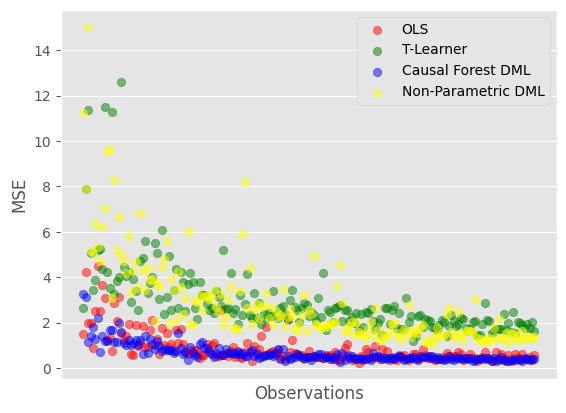

In [ ]:

# Use the n values to set the ticks
# Create the scatter plot
plt.style.use('ggplot')
plt.scatter(mse_ols['n'], mse_ols['MSE'], alpha=0.5, color='red', label='OLS')
plt.scatter(mse_t['n'], mse_t['MSE'], alpha=0.5, color='green', label='T-Learner')
plt.scatter(mse_cf_dml['n'], mse_cf_dml['MSE'], alpha=0.5, color='blue', label='Causal Forest DML')
plt.scatter(mse_npm['n'], mse_npm['MSE'], alpha=0.5, color='yellow', label='Non-Parametric DML')

# Set the x-ticks and y-ticks
plt.xticks([])
# Set labels and legend
plt.xlabel('Observations')
plt.ylabel('MSE')
plt.legend()

# Show the plot
plt.show()